# Convolutional Autoencoder for segmentation

In [1]:
from models.CAE import *

import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


# Load Data

In [2]:
x_train = np.load('./dataset/x_train.npy')
y_train = np.load('./dataset/y_train.npy')
x_test = np.load('./dataset/x_test.npy')
y_test = np.load('./dataset/y_test.npy')

# data already preprocessed
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(213, 64, 64, 1) (213, 64, 64, 1)
(54, 64, 64, 1) (54, 64, 64, 1)


# Create Convolutional Autoencoder Class

In [3]:
seg_model = CAE(x_train[0].shape, do_batch_norm = True, do_drop = True)

In [4]:
seg_model.show_model() # show architecture of model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
__________

# Train Model

In [5]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 64)

Train on 170 samples, validate on 43 samples
Epoch 1/100
170/170 [==============================] - 4s 22ms/step - loss: 0.6438 - dice_coef: 0.3389 - val_loss: 0.7329 - val_dice_coef: 0.4431
Epoch 2/100
170/170 [==============================] - 0s 365us/step - loss: 0.4801 - dice_coef: 0.4475 - val_loss: 0.5711 - val_dice_coef: 0.5206
Epoch 3/100
170/170 [==============================] - 0s 359us/step - loss: 0.3966 - dice_coef: 0.5114 - val_loss: 0.3910 - val_dice_coef: 0.5982
Epoch 4/100
170/170 [==============================] - 0s 341us/step - loss: 0.3336 - dice_coef: 0.5605 - val_loss: 0.2972 - val_dice_coef: 0.6594
Epoch 5/100
170/170 [==============================] - 0s 353us/step - loss: 0.2884 - dice_coef: 0.6028 - val_loss: 0.2618 - val_dice_coef: 0.7027
Epoch 6/100
170/170 [==============================] - 0s 341us/step - loss: 0.2549 - dice_coef: 0.6420 - val_loss: 0.2500 - val_dice_coef: 0.7278
Epoch 7/100
170/170 [==============================] - 0s 347us/step - los

170/170 [==============================] - 0s 359us/step - loss: 0.0606 - dice_coef: 0.9156 - val_loss: 0.1059 - val_dice_coef: 0.8888
Epoch 57/100
170/170 [==============================] - 0s 353us/step - loss: 0.0606 - dice_coef: 0.9162 - val_loss: 0.1023 - val_dice_coef: 0.8912
Epoch 58/100
170/170 [==============================] - 0s 347us/step - loss: 0.0595 - dice_coef: 0.9169 - val_loss: 0.1055 - val_dice_coef: 0.8902
Epoch 59/100
170/170 [==============================] - 0s 341us/step - loss: 0.0593 - dice_coef: 0.9170 - val_loss: 0.1088 - val_dice_coef: 0.8889
Epoch 60/100
170/170 [==============================] - 0s 347us/step - loss: 0.0585 - dice_coef: 0.9178 - val_loss: 0.1112 - val_dice_coef: 0.8865
Epoch 61/100
170/170 [==============================] - 0s 341us/step - loss: 0.0585 - dice_coef: 0.9188 - val_loss: 0.1062 - val_dice_coef: 0.8951
Epoch 62/100
170/170 [==============================] - 0s 347us/step - loss: 0.0584 - dice_coef: 0.9193 - val_loss: 0.1210 -

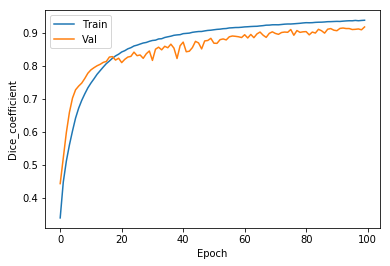

In [6]:
plot_dice(history)

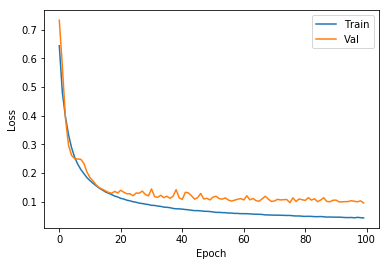

In [7]:
plot_loss(history)

# Show result

In [8]:
preds = seg_model.predict(x_test)

Original test data | true masked data | prediction data

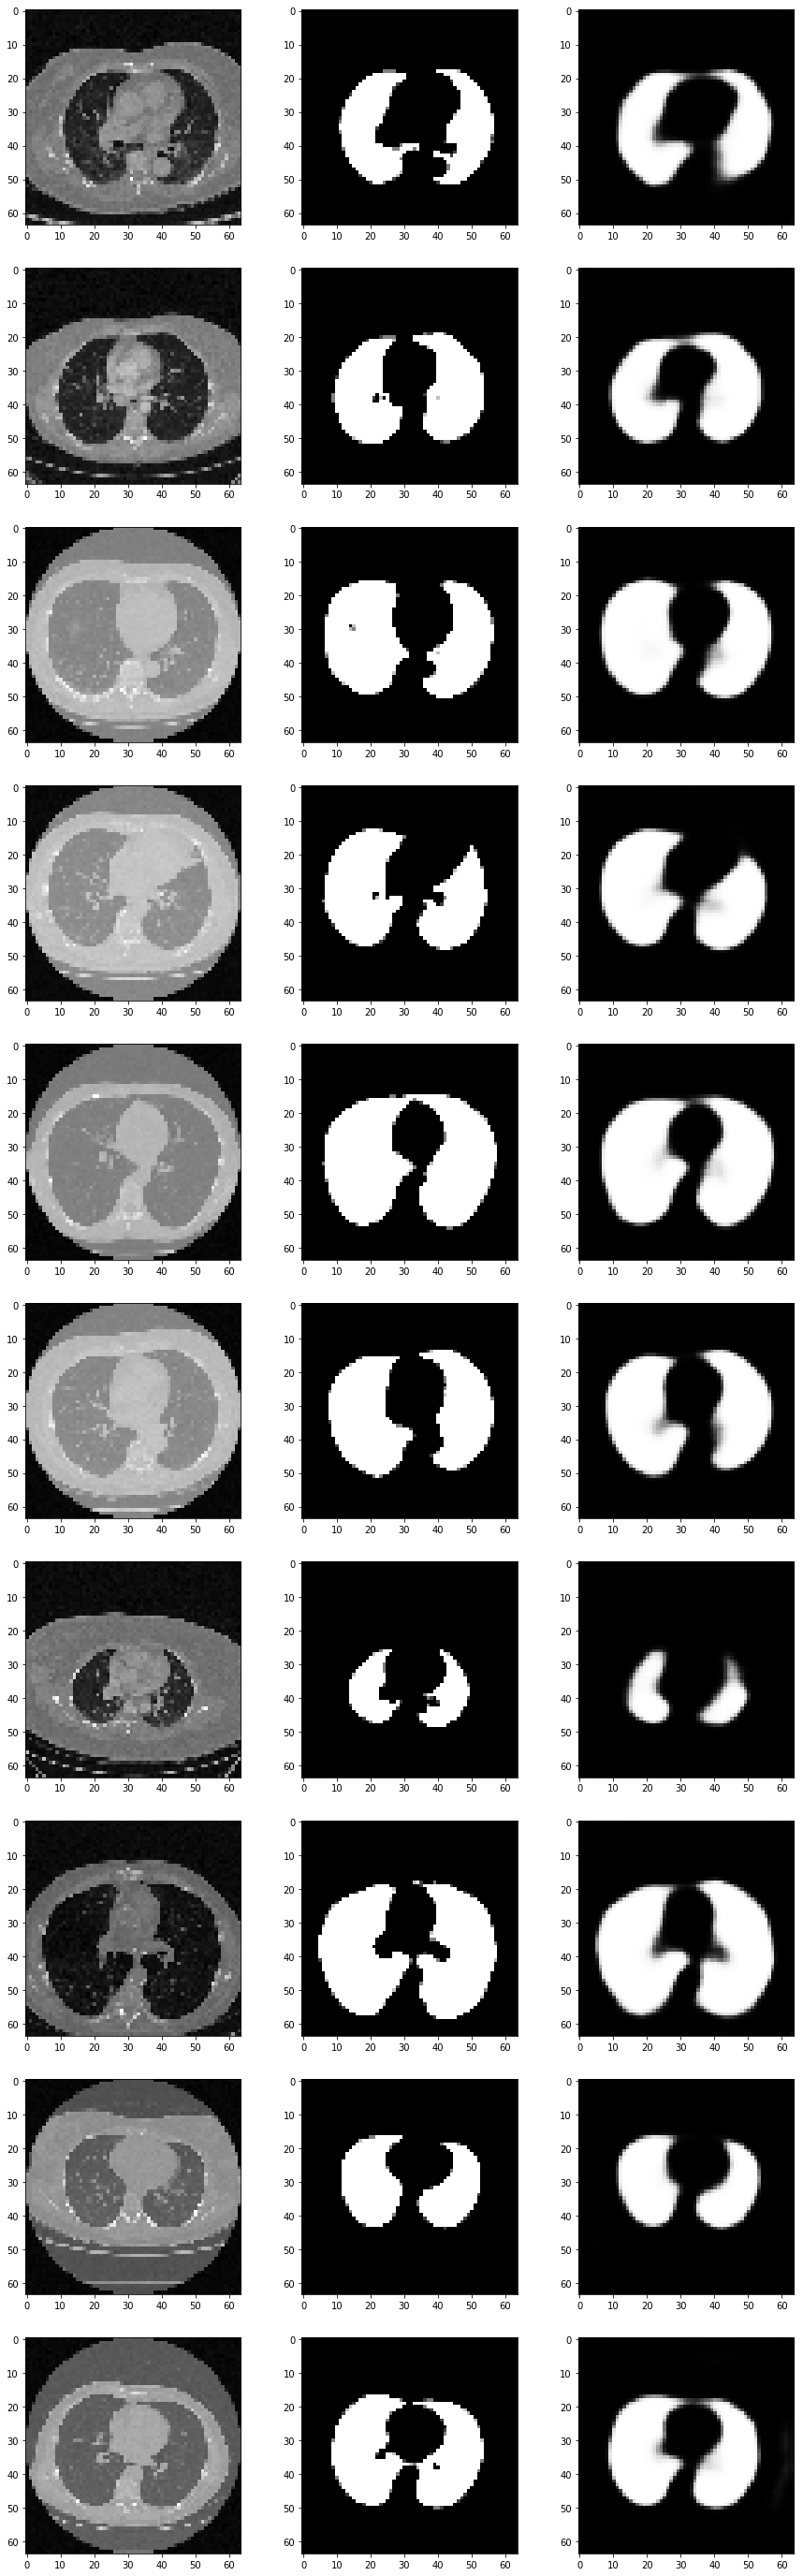

In [9]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')